## Analysing textual features

In [7]:
import keras
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [8]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [9]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 500 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

In [10]:
DOMAIN = 'firefox'
DIR = 'data/processed/{}'.format(DOMAIN)
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))

In [11]:
import os

# uncased_L-12_H-768_A-12
# multi_cased_L-12_H-768_A-12
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [12]:
from keras_bert import load_vocabulary

token_dict = load_vocabulary(vocab_path)

In [13]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, '{}_pairs.csv'.format(DOMAIN)))
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [14]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

Creating the buckets...


In [15]:
experiment.load_ids()

Reading bug ids


In [16]:
len(baseline.bug_ids)

115814

In [17]:
experiment.load_bugs()

In [18]:
issues_by_buckets = experiment.get_buckets_for_bugs()

In [19]:
%%time

baseline.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')

Reading train data
Reading bug ids
CPU times: user 3min 34s, sys: 30.2 ms, total: 3min 34s
Wall time: 3min 34s


In [20]:
title_corpus = [baseline.bug_set[i]['title'][:MAX_SEQUENCE_LENGTH_T] for i in tqdm(baseline.bug_ids)]
description_corpus = [baseline.bug_set[i]['description'][:MAX_SEQUENCE_LENGTH_D] for i in tqdm(baseline.bug_ids)]

100%|██████████| 115814/115814 [00:00<00:00, 1317727.40it/s]


In [21]:
title_length = [len(baseline.bug_set[i]['title'].split(' ')) for i in tqdm(baseline.bug_ids)]
description_length = [len(baseline.bug_set[i]['description'].split(' ')) for i in tqdm(baseline.bug_ids)]

100%|██████████| 115814/115814 [00:00<00:00, 160215.55it/s]


          short_desc
count  115814.000000
mean       16.032829
std         7.983123
min         2.000000
25%        11.000000
50%        15.000000
75%        19.000000
max       182.000000
         description
count  115814.000000
mean      150.394555
std       544.415159
min         2.000000
25%        49.000000
50%        84.000000
75%       138.000000
max     21160.000000


Text(0.5, 0, 'número de tokens')

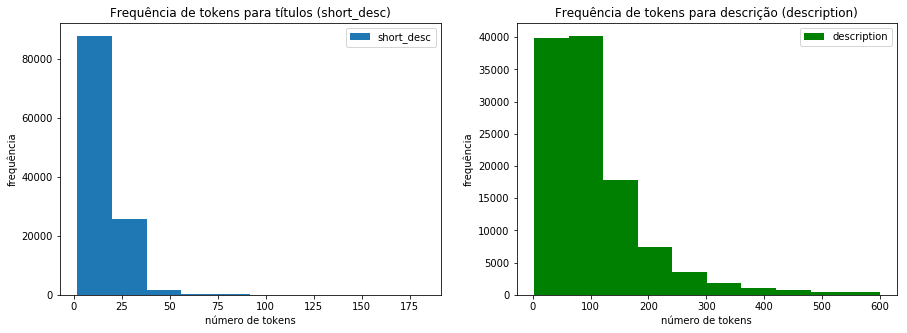

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# Title
df_title = pd.DataFrame(title_length, columns=['short_desc'])
print(df_title.describe())
ax = df_title.plot.hist(ax=axes[0])
ax.set_title('Frequência de tokens para títulos (short_desc)')
ax.set_ylabel('frequência')
ax.set_xlabel('número de tokens')
# Description
df_desc = pd.DataFrame(description_length, columns=['description'])
print(df_desc.describe())
df_desc = df_desc[df_desc['description'] <= 600]
ax = df_desc.plot.hist(color='g', ax=axes[1])
ax.set_title('Frequência de tokens para descrição (description)')
ax.set_ylabel('frequência')
ax.set_xlabel('número de tokens')

In [15]:
def filter_words(corpus, callback):
    corpus_filtered_words = [row.split(' ') for row in corpus]
    corpus_in_words = []
    for row in corpus_filtered_words:
        corpus_in_words += [word for word in row if callback(len(word))]
    return corpus_in_words

### Word cloud title

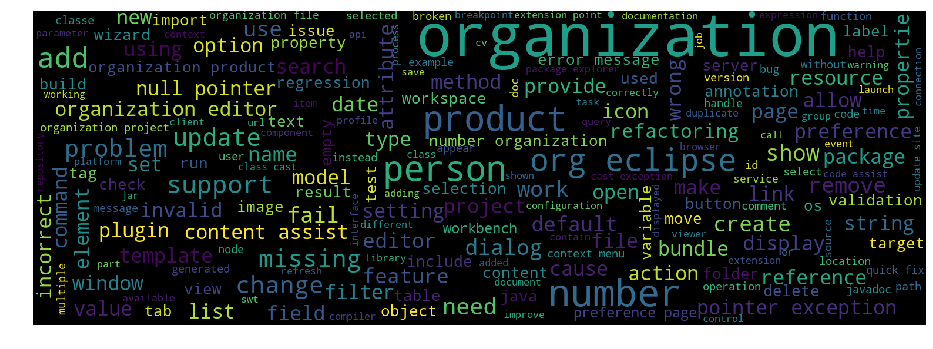

CPU times: user 10.2 s, sys: 317 ms, total: 10.5 s
Wall time: 10.3 s


In [16]:
%%time

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(" ".join(title_corpus))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word cloud description

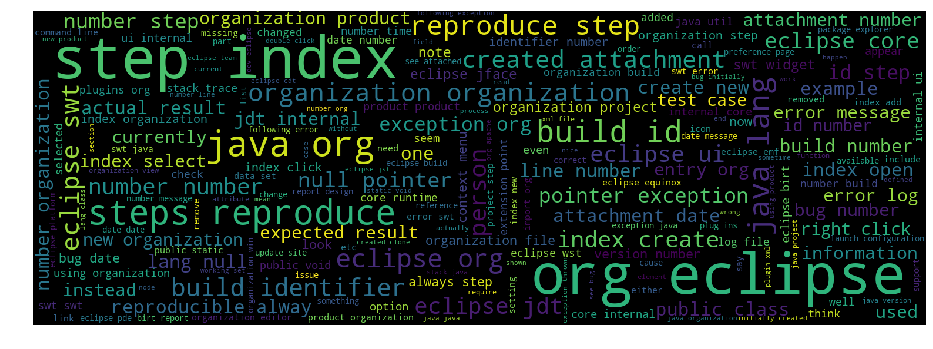

CPU times: user 42.2 s, sys: 1.28 s, total: 43.5 s
Wall time: 43.4 s


In [17]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(" ".join(description_corpus))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Word cloud 2 words in title

In [18]:
corpus_2_words = [row.split(' ') for row in title_corpus]
title_corpus_2_words = []
for row in corpus_2_words:
    title_corpus_2_words += [word for word in row if len(word) == 2]

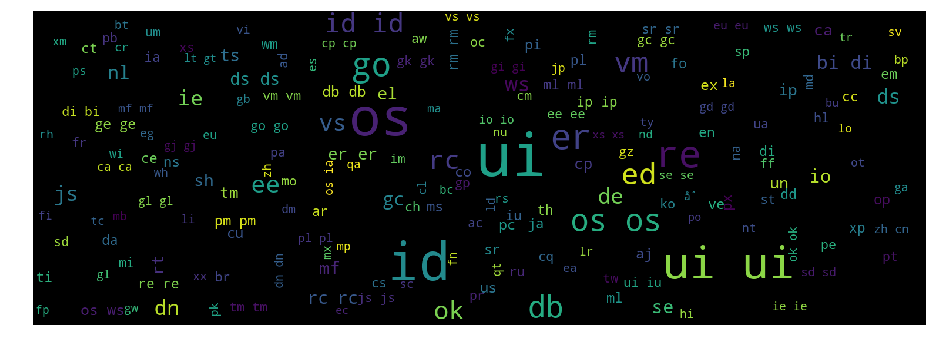

CPU times: user 1.05 s, sys: 141 ms, total: 1.19 s
Wall time: 1.04 s


In [19]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(' '.join(title_corpus_2_words))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word cloud 2 words in description

In [20]:
corpus_2_words = [row.split(' ') for row in description_corpus]
desc_corpus_2_words = []
for row in corpus_2_words:
    desc_corpus_2_words += [word for word in row if len(word) == 2]

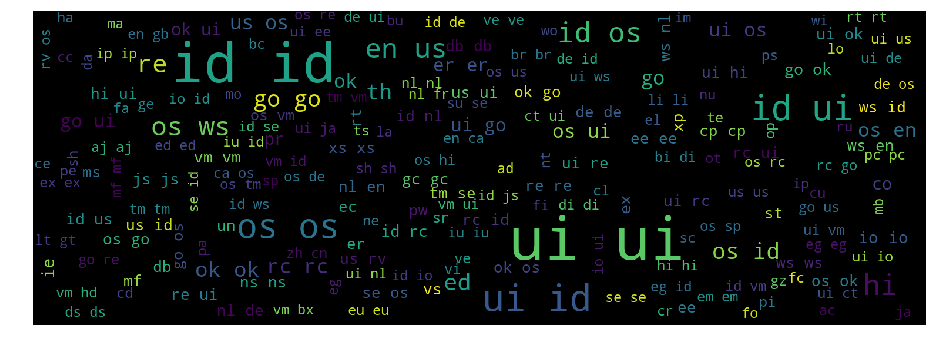

CPU times: user 2.4 s, sys: 157 ms, total: 2.56 s
Wall time: 2.41 s


In [21]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(' '.join(desc_corpus_2_words))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word cloud 1 word in title

In [22]:
corpus_1_word = [row.split(' ') for row in title_corpus]
title_corpus_1_word = []
for row in corpus_1_word:
    title_corpus_1_word += [word for word in row if len(word) == 1]

In [23]:
freq_words = {}
for word in title_corpus_1_word:
    if word not in freq_words:
        freq_words[word] = 0
        
    freq_words[word] += 1

Text(0.5, 0, 'frequency')

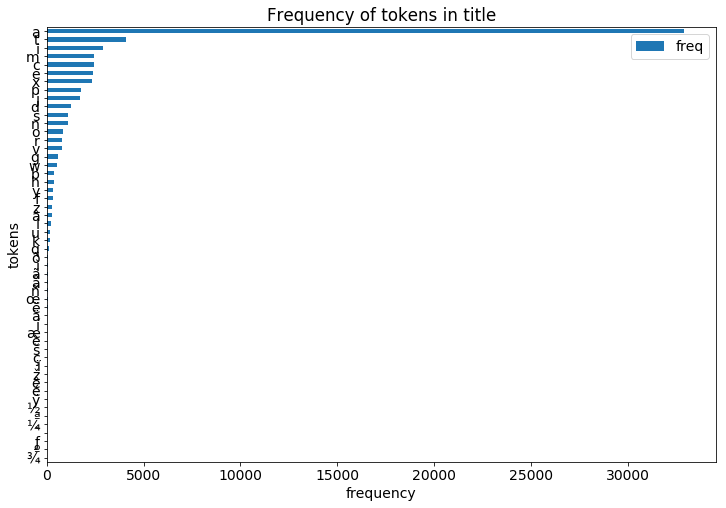

In [24]:
MEDIUM_SIZE = 16
SMALL_SIZE = 14

plt.rc('font', size=SMALL_SIZE)

df = pd.DataFrame(freq_words, columns=list(freq_words), index=range(len(freq_words))).transpose()[[0]]
df.columns = ['freq']
ax = df.sort_values('freq', ascending=True).plot.barh(figsize=(12, 8))
ax.set_title('Frequency of tokens in title')
ax.set_ylabel('tokens')
ax.set_xlabel('frequency')

### Word cloud 1 word in title

In [25]:
corpus_1_word = [row.split(' ') for row in description_corpus]
desc_corpus_1_word = []
for row in corpus_1_word:
    desc_corpus_1_word += [word for word in row if len(word) == 1]

In [26]:
freq_words = {}
for word in desc_corpus_1_word:
    if word not in freq_words:
        freq_words[word] = 0
        
    freq_words[word] += 1

Text(0.5, 0, 'frequency')

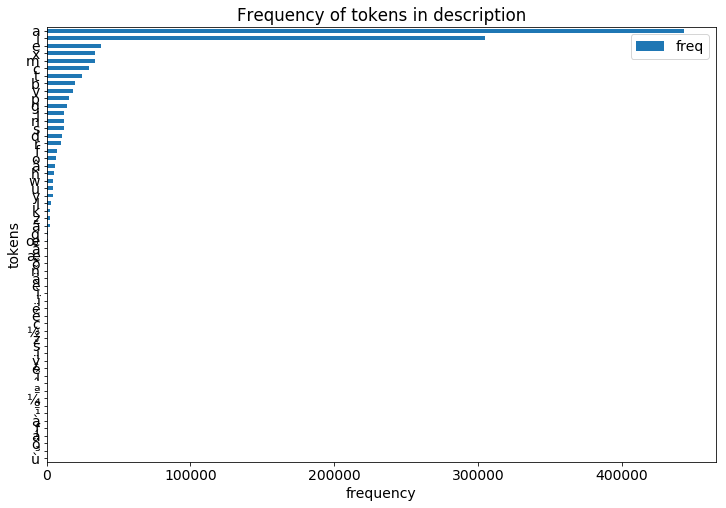

In [27]:
MEDIUM_SIZE = 16
SMALL_SIZE = 14

plt.rc('font', size=SMALL_SIZE)

df = pd.DataFrame(freq_words, columns=list(freq_words), index=range(len(freq_words))).transpose()[[0]]
df.columns = ['freq']
ax = df.sort_values('freq', ascending=True).plot.barh(figsize=(12, 8))
ax.set_title('Frequency of tokens in description')
ax.set_ylabel('tokens')
ax.set_xlabel('frequency')

### Distribution of words in title

In [28]:
dist_word = [row.split(' ') for row in title_corpus]
size_tokens = []
for row in dist_word:
    size_tokens += [len(word) for word in row]

In [29]:
from collections import Counter
freq_tokens = Counter(size_tokens)

Text(0.5, 0, 'token_size')

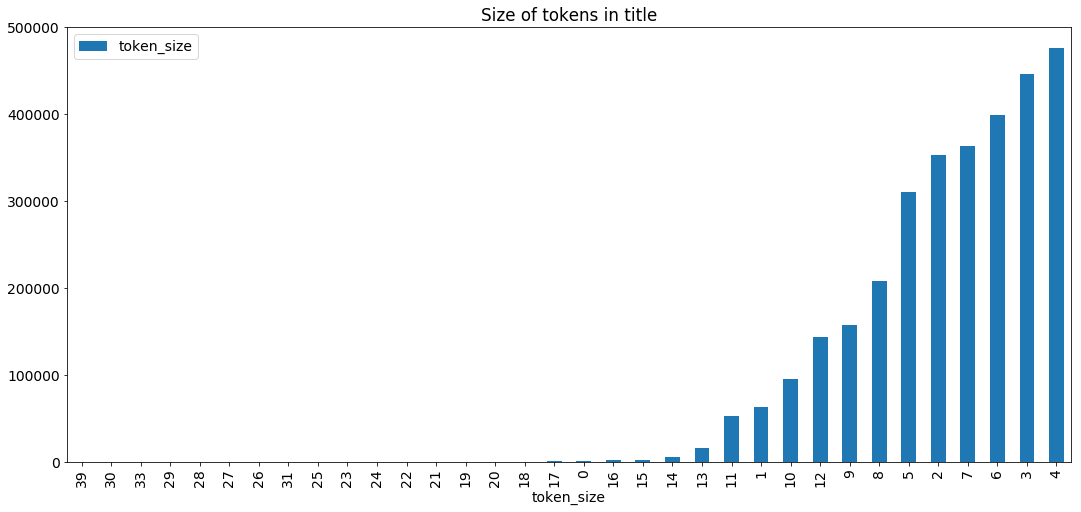

In [30]:
df = pd.DataFrame(freq_tokens, index=range(len(freq_tokens))).transpose()[[0]]
df.columns = ['token_size']
ax = df.sort_values('token_size', ascending=True).plot.bar(figsize=(18, 8))
ax.set_title('Size of tokens in title')
ax.set_xlabel('token_size')

In [31]:
def filter_by_words_title(token_size):
    return token_size == 6

corpus_filtered = filter_words(title_corpus, filter_by_words_title)
len(corpus_filtered)

399520

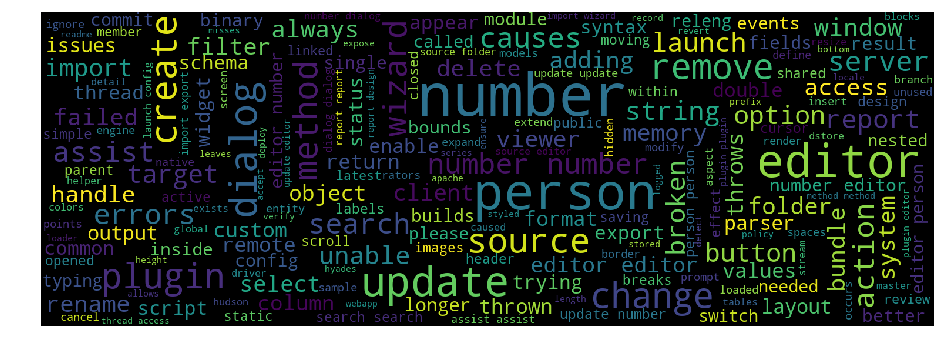

CPU times: user 1.96 s, sys: 141 ms, total: 2.1 s
Wall time: 1.95 s


In [32]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(' '.join(corpus_filtered))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Distribution of words in description

In [33]:
dist_word = [row.split(' ') for row in description_corpus]
size_tokens = []
for row in dist_word:
    size_tokens += [len(word) for word in row]

In [34]:
from collections import Counter
freq_tokens = Counter(size_tokens)

Text(0.5, 0, 'token_size')

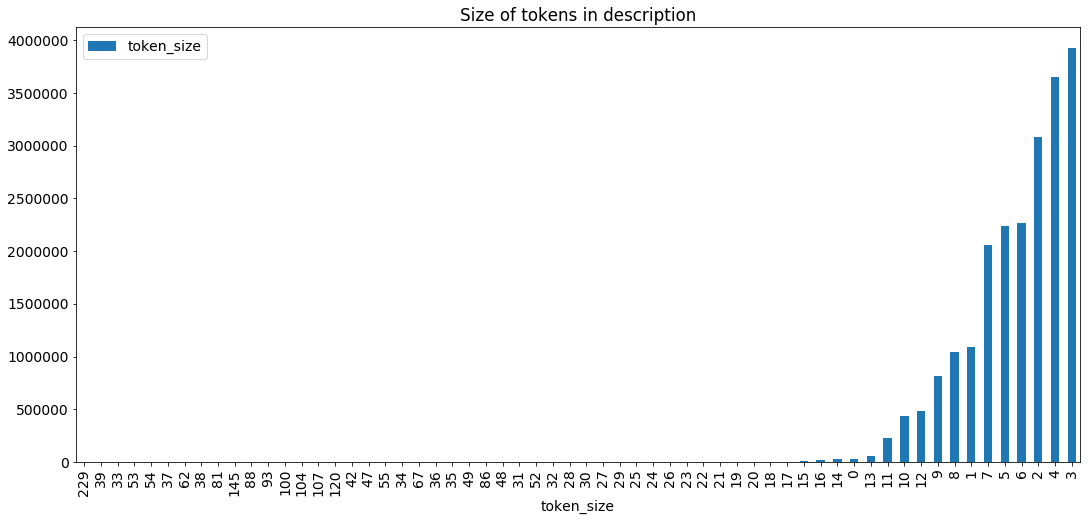

In [35]:
df = pd.DataFrame(freq_tokens, index=range(len(freq_tokens))).transpose()[[0]]
df.columns = ['token_size']
ax = df.sort_values('token_size', ascending=True).plot.bar(figsize=(18, 8))
ax.set_title('Size of tokens in description')
ax.set_xlabel('token_size')

In [36]:
def filter_by_words_desc(token_size):
    return token_size == 3

corpus_filtered = filter_words(description_corpus, filter_by_words_desc)
len(corpus_filtered)

3928376

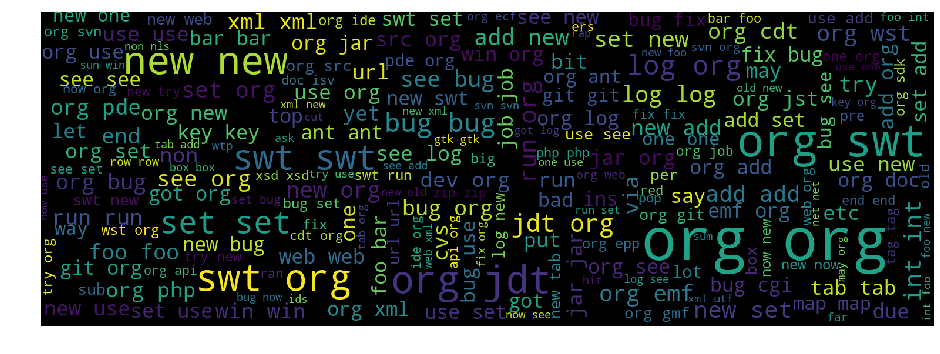

CPU times: user 4.61 s, sys: 116 ms, total: 4.72 s
Wall time: 4.57 s


In [37]:
%%time

wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535).generate(' '.join(corpus_filtered))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Visualize a random bug

In [38]:
bug_selected = np.random.choice(baseline.bug_ids, 1)[0]

bug = baseline.bug_set[bug_selected]

bug

{'bug_severity': '1\n',
 'bug_status': '1\n',
 'component': '434\n',
 'creation_ts': '2010-10-20 19:46:00 -0400',
 'delta_ts': '2010-10-23 22:33:00 -0400',
 'description': 'build identifier m from eclipse i had suffered by slow of editing jspx i used use person with number editing jspx file in jsp editor is very slow now i move to a faster machine and use win with just released product find out that is even slower than before one h tag in date i cant tolerate this any more this bug slows down i programming so bad i love wtp and i dont want to move to other organization please correct this bug or tell me how to work arround now thanks reproducible always',
 'description_word': array([   41,   383,   177,    54,     2,    18,   654, 16027,    99,
         1605,    20,   904, 10630,    18,   256,   153,    50,    32,
           10,   904, 10630,    39,    12,   680,    46,    13,   559,
         1605,   329,    18,   517,     8,    11,  3548,  1133,    17,
          153,   258,    32,   3

#### Total missing values after preprocessing

In [39]:
bugs_empty_desc = [idx for idx in list(baseline.bug_set) if baseline.bug_set[idx]['description'] == '']
bugs_empty_title = [idx for idx in list(baseline.bug_set) if baseline.bug_set[idx]['title'] == '']

In [40]:
len(bugs_empty_title), len(bugs_empty_desc)

(29, 4975)

In [41]:
df = pd.read_csv(DATASET)
df[df['bug_id'].isin(bugs_empty_desc)]

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
3208,4366,normal,RESOLVED,UI,2001-10-11 08:36:00 -0400,2002-02-12 10:51:00 -0500,,[],P3,JDT,FIXED,Function to reactivate argument hover would be...,2.0
3796,4976,enhancement,CLOSED,Compare,2001-10-15 09:20:00 -0400,2009-08-30 02:21:33 -0400,,[],P3,Platform,WONTFIX,Replace from local history should use a table ...,2.0
3885,5074,normal,RESOLVED,UI,2001-10-18 10:10:00 -0400,2001-10-22 12:35:09 -0400,,[],P3,JDT,WORKSFORME,Problems with editor linking,2.0
4006,5200,normal,RESOLVED,Core,2001-10-24 07:57:00 -0400,2002-01-11 09:08:56 -0500,,[],P3,JDT,FIXED,SetClasspathOperation must close root only whe...,2.0
4533,5739,enhancement,RESOLVED,Build,2001-11-09 16:04:00 -0500,2003-05-13 15:21:53 -0400,,35144,P3,PDE,DUPLICATE,[build] PDE templates don't generate JavaDoc,1.0
4856,6063,normal,VERIFIED,Debug,2001-11-19 09:34:00 -0500,2002-01-21 18:44:31 -0500,,[],P2,JDT,FIXED,Snippet & Display should catch up with changes...,2.0
4869,6076,normal,RESOLVED,UI,2001-11-19 14:03:00 -0500,2002-05-13 11:32:06 -0400,,[],P3,Platform,FIXED,"Problems from first ""no mouse day""",2.0
4881,6088,normal,VERIFIED,Debug,2001-11-19 19:15:00 -0500,2002-01-14 17:13:20 -0500,,[],P2,Platform,FIXED,"Move ""qualified name"" rendering to java debug",2.0
4882,6089,normal,VERIFIED,Debug,2001-11-19 19:47:00 -0500,2002-03-20 19:42:17 -0500,,[],P1,JDT,FIXED,display view code assist cotext should be rece...,2.0
4885,6092,normal,VERIFIED,UI,2001-11-20 06:00:00 -0500,2002-01-15 09:38:07 -0500,,[],P3,JDT,FIXED,JavaEditor should honor the tab width setting ...,2.0


In [42]:
len(bugs_empty_desc) / len(baseline.bug_set) * 100.0

1.3780934388902124